# A Hybrid Fraud Detection Model

Every fraud detection model in models.py by itself is a valuable model that is capable of finding suspicious service providers. The real power of a hybrid detection model is the combination of all these models into one. Often, the real fraudsters know how to stay under the radar on any aspect that is typically investigated. Combining all these models into one makes financial criminals that are just a little bit smarter than their obvious colleagues float to the surface.

All models are run with a set of parameters and a weight and the scores are then combined, as explained in models_explanation.pdf. Here we show one particular run of the hybrid model, with one set of model parameters and model weights.

This can be wrapped into a nice GUI in which the model parameters can be set and the results (visually) investigated. This demo just runs from the notebook. Feel free to see what happens when the model ingredients are tweaked!

### Running the models
Running the models depends on a set of parameters, and then the results are gathered into a data structure that is called the hitlist here. Below, the run is initialized and controlled by a function called "process()". The argument to the function is a dictionary of parameter settings of all models that need to be used.

In [1]:
import models, pickle
import pandas as pd

# The warnings filtered are the "Setting with copy" thing.
import warnings
warnings.filterwarnings('ignore')

In [2]:
def process(modelsdict):
    # The data needs to be read here. In general, this would likely be done elsewhere.
    datafile = './data/mock_healthcare.pickle'
    df = open(datafile, 'rb')
    data = pickle.load(df)
    df.close()

    # Initialization of data structures for results. Outdata is a helper for if visualization in a GUI is desired.
    hitlist = pd.DataFrame({'Provider_ID':[], 'Score':[], "Model":[], "Monetary":[], 'Weight':[]})
    outdata = {}

    allmodels = modelsdict.keys()
    
    for model in allmodels:
        if   model == 'costs': hitlist, outdata = models.cost_per_member(data, modelsdict[model], hitlist, outdata)
        elif model == 'billing':   hitlist, outdata = models.billing_pattern(data, modelsdict[model], hitlist, outdata)
        elif model == 'weekends': hitlist, outdata = models.weekends_holidays(data, modelsdict[model], hitlist, outdata)
        elif model == 'seasonality': hitlist, outdata = models.seasonality(data, modelsdict[model], hitlist, outdata)
        elif model == 'increasing_revenue': hitlist, outdata = models.rising_revenue(data, modelsdict[model], hitlist, outdata)
        elif model == 'combination': hitlist, outdata = models.combination_codes(data, modelsdict[model], hitlist, outdata)
        elif model == 'periodic_often': hitlist, outdata = models.periodic_often(data, modelsdict[model], hitlist, outdata)
        elif model == 'freely_billed': hitlist, outdata = models.freely_billed(data, modelsdict[model], hitlist, outdata)
        elif model == 'fraction_expensive': hitlist, outdata = models.fraction_expensive(data, modelsdict[model], hitlist, outdata)
        else:
            print("Model not yet implemented!")
    
    totals = total_score(hitlist)

    return totals, hitlist

The models dict that is input to that function has dicts in it, one per model, with the model parameters. Below, one example is filled up and consequently run, resulting in what would be the hitlist for this specific set of options and parameters. Note that models do not have predefined defaults for the parameters, they *must* be specified. In a realistic implementation, the dictionary can be filled up by a GUI or some other, more user-friendly way.

In [3]:
# Example of the model settings. All setting options are listed as well, if they exist.
# If any model needs to be turned off, it can be removed. 
# The weight can be set to 0, in which case it will be run, but not count towards the total score. Results are available though.

modelsdict = {
    'costs': {'Grouping':'Per specialism',                   # Options: ['Per specialism', 'By determined peer group', 'Overall']
              'Outlier definition': 'Above 90th percentile', # Options: ['Above 90th percentile', 'Above 95th percentile', 'Statistical outlier'],
              'Weight': 1
             },
    'combination': {'Weight': 1},
    'weekends': {'Weight': 1,
                'Flag': 'too many'   # No other options implemented
                },
    'billing': {'Weight': 0.5},
    'seasonality': {'Weight': 1},
    'increasing_revenue': {'Weight': 2},
    'periodic_often': {'Weight': 1, 
                'maxnumber': 2  # Any integer should work, but most don't work as well as say 2 or 3...
                      },
    'freely_billed':{'Weight': 1, 
                    "Grouping":'per_specialism',    # Options: 'overall' 'per_specialism'
                    "Group_codes": "per_procedure", # Options: 'overall' 'per_procedure'
                    "Outlier":'statistical'         # Options: 'statistical' 'percentile'
                    },
    'fraction_expensive': {'Weight': 1, 
                        "Grouping":'per_specialism',  # Options: 'overall', 'per_specialism'
                        "Ratio": 'price',             # Options:['number', 'price']}
                        "Outlier":'percentile'        # Options: 'statistical', 'percentile'
                        }
}


In [4]:
# To construct the total score after running all models:
def total_score(hitlist):
    """ 
    From the hitlist, construct the actual hitlist, with one entry per flagged provider.
    """

    hitlist['scorexweight'] = hitlist.Score * hitlist.Weight

    # Combine scores, monetary values and construct total scores and hitlist
    per_prov = hitlist.groupby('Provider_ID')
    weighted_total = per_prov.scorexweight.sum()
    sum_weighted = weighted_total / per_prov.Weight.sum()

    # For now, monetary amounts are *unweighted*
    total_loss = per_prov.Monetary.sum()

    # Number of flags
    n_flags = per_prov.Model.count()

    totals = pd.concat([sum_weighted, total_loss, n_flags], axis=1)
    totals.rename(columns={0:'Weighted_score', 'Model':'N_flags'}, inplace=True)

    # Total Score is a a 40-40-20 weighted sum of weighted score, monetary and N_flags
    # It therefore, by definition, runs from 0 to 100.
    max_w_score = totals.Weighted_score.max()
    max_mon = totals.Monetary.max()
    max_flags = totals.N_flags.max()

    totals['Total_score'] = 40 * totals.Weighted_score / max_w_score + \
                            40 * totals.Monetary / max_mon + \
                            20 * totals.N_flags / max_flags


    totals.sort_values('Total_score', ascending=False, inplace=True)



    return totals


In [5]:
# Finally, the model can be run:

total_scores, hitlist = process(modelsdict)

The result of this model is a lits of providers with their respective total fraud risk score, as well as an estimate for the total monetary loss. Below, the top 5 is listed, and there is an interactive graph (meaning that you can zoom and pan) showing those values plotted against each other, a mouse-over will show you the provider ID you're looking at. The size and color mean the same thing: the number of different fraud models the provider scored on. Feel free to explore more!

In [23]:
total_scores[['Total_score', 'Monetary']].head(5)

,Total_score,Monetary
Provider_ID,,
1000429.0,64.149195,2876.445909
1000257.0,58.644061,1830.817971
1000220.0,57.890785,2142.000000
1000319.0,57.172704,2212.108197
1000179.0,56.271528,2233.000000


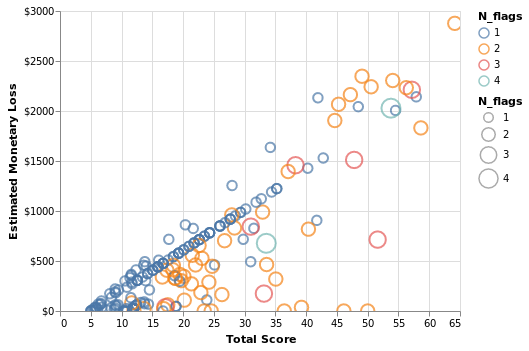

In [30]:
import altair as alt
alt.Chart(total_scores.reset_index()).mark_point().encode(
    alt.X("Total_score", axis=alt.Axis(title='Total Score')),
    alt.Y("Monetary", axis=alt.Axis(format='$f', title='Estimated Monetary Loss')),
    alt.Color("N_flags:N"),
    size="N_flags",
    tooltip=['Provider_ID:Q', 'Total_score', 'Monetary', 'N_flags']
).interactive()